In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import warnings


mpl.use("Cairo")  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns

import gumbi as gmb
from candas.test import QuantStudio

import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / "data"
graph_pth = fig_pth / "graphics"
graph_pth.mkdir(exist_ok=True)

In [2]:
plt.style.use('style.mplstyle')

%config InlineBackend.figure_format = 'retina'

from utils import savefig

# Load data

In [3]:
cmax = 50

JG069J = (
    QuantStudio(data_pth / "JG069J Final TB Experiment.xlsx", "JG069J")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax, method="min-max")
    .invert_fluorophore("HEX")
)

JG069J.reactions.wide = JG069J.reactions.wide.drop(columns=["Sample"]).merge(
    pd.read_csv(data_pth / "JG069J Plate Map.csv"), on="Well"
)

In [4]:
JG069J.reactions.neaten()
JG069J.extract_endpoints(cmax=cmax, name="FAM-HEX", method="diff")
endpoints = JG069J.endpoints

# endpoints = endpoints[
#     ~((endpoints.PRDM1==5) & (endpoints.ARG1==2))
# ]

In [5]:
gp_config = {
    "continuous_dims": ["GBP6", "ARG1", "TMCC1", "PRDM1"],
    #'linear_dims': ['GBP6', 'ARG1', 'TMCC1', 'PRDM1']
}

ds = gmb.DataSet(endpoints, outputs=["FAM-HEX"])
gp = gmb.GP(ds).fit(**gp_config)

Saving fig_4A__atomic_hornet in /home/john/projects/can-manuscript/fig_4__galactic_gorilla/graphics: [.svg] [.png] done


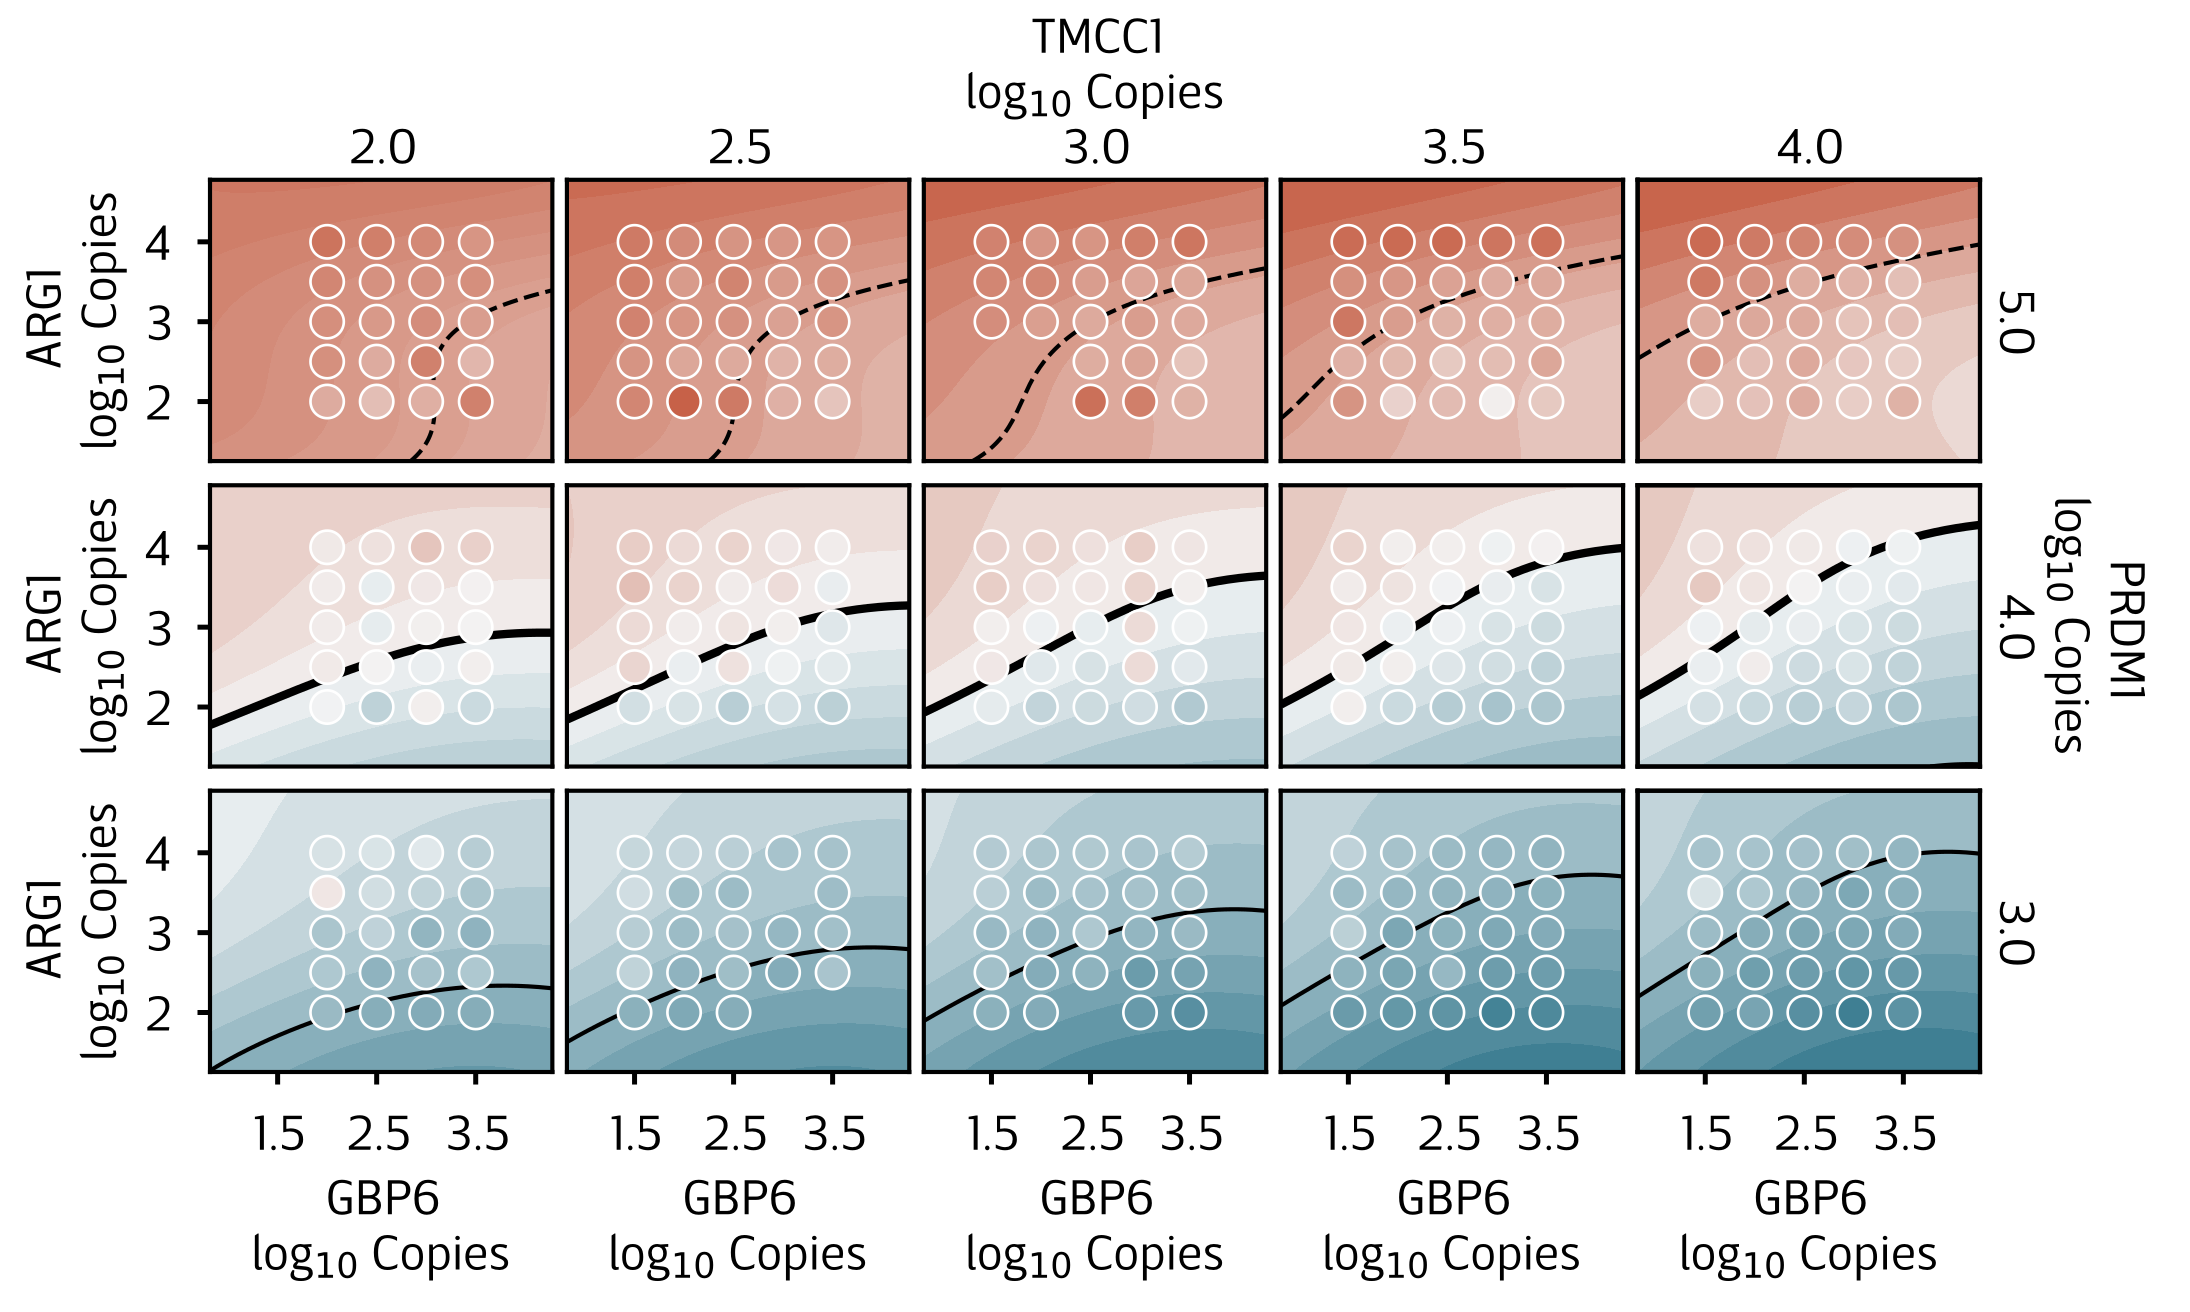

In [14]:
width = 3.65
height = 2.187
figsize = (width, height)
ticklabelsize = 6
labelsize = 6

mar_l = 0.35  # 0.237
mar_r = 0.35
mar_t = 0.3
mar_b = 0.4

hue = "FAM-HEX"
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax =+extent)
cmap = sns.diverging_palette(20, 220, as_cmap=True)

g = sns.relplot(
    data=endpoints,
    col="TMCC1",
    row="PRDM1",
    x="GBP6",
    y="ARG1",
    hue=hue,
    hue_norm=norm,
    row_order=[5.0, 4.0, 3.0],
    palette=cmap,
    legend=False,
    kind="scatter",
    # height=fig_size[1]/4, aspect=(fig_size[0]/6)/(fig_size[1]/4),
    s=4**2,
    zorder=10,
    facet_kws={
        "margin_titles": False,
        "despine": False,
    },
)

fig = plt.gcf()
fig.set_size_inches(figsize)

for (prdm1, tmcc1), ax in g.axes_dict.items():

    at = gp.parray(PRDM1=prdm1, TMCC1=tmcc1)
    XY = gp.prepare_grid(at=at)
    sig = gp.predict_grid()

    plt.sca(ax)
    pp = gmb.ParrayPlotter(x=XY["GBP6"], y=XY["ARG1"], z=sig)
    cf = pp(plt.contourf, cmap=cmap, norm=norm, zorder=-10)
    #     pp.colorbar(ax=ax)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pp(
            plt.contour,
            levels=[-0.5, +0.5],
            linewidths=0.5,
            colors="k",
            norm=norm,
            zorder=-5,
        )
        pp(plt.contour, levels=[0.0], linewidths=1, colors="k", norm=norm, zorder=-5)
    ax.tick_params(axis="both", labelsize=ticklabelsize)
    ax.set_title("", fontsize=labelsize)
    if prdm1 == 5.0:
        ax.set_title(f"{tmcc1:.1f}", fontsize=labelsize, pad=2)
        if tmcc1 == 3.0:
            ax.set_title(f"TMCC1\n"+r"log$_{10}$"+f" Copies\n{tmcc1:.1f}", fontsize=labelsize, pad=2)
    if tmcc1 == 4.0:
        ax2 = ax.twinx()
        ax2.set_ylabel(
            f"{prdm1:.1f}", va="bottom", fontsize=labelsize, rotation=270, labelpad=1
        )
        if prdm1 == 4.0:
            ax2.set_ylabel(
                f"PRDM1\n"+r"log$_{10}$"+f" Copies\n{prdm1:.1f}",
                va="bottom",
                fontsize=labelsize,
                rotation=270,
                labelpad=1,
            )
        ax2.set_yticks([])
    else:
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=2)

    ax.set_xticks([1.5, 2.5, 3.5])
    ax.set_yticks([2, 3, 4])

    ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
    
    if prdm1 != 3.0:
        ax.xaxis.set_tick_params(length=0)
    else:
        ax.set_xlabel(f"GBP6\n"+r"log$_{10}$"+f" Copies")
        ax.xaxis.set_tick_params(length=1.5, width=0.6)

    if tmcc1 != 2.0:
        ax.yaxis.set_tick_params(length=0)
    else:
        ax.set_ylabel(f"ARG1\n"+r"log$_{10}$"+f" Copies")
        ax.yaxis.set_tick_params(length=1.5, width=0.6)

plt.subplots_adjust(
    left=mar_l / width,
    right=1 - mar_r / width,
    top=1 - mar_t / height,
    bottom=mar_b / height,
)

savefig(fig, alias="atomic_hornet")

Saving fig_4A__atomic_hornet__legend in /home/john/projects/can-manuscript/fig_4__galactic_gorilla/graphics: [.svg] [.png] done


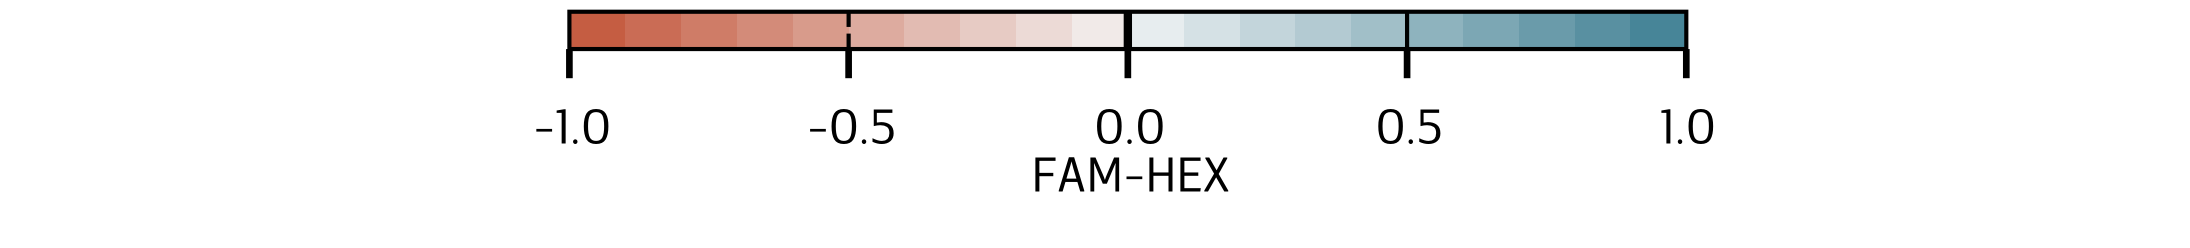

In [7]:
width = 3.65
height = 0.829 / 2
figsize = (width, height)
ticklabelsize = 6
labelsize = 6

fig = plt.figure()
fig.set_figwidth(width)
fig.set_figheight(height)

hue = "FAM-HEX"
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)
# cmap = sns.diverging_palette(20, 220, as_cmap=True)

img = plt.contourf(
    np.array([[-extent, 0], [0, +extent]]), cmap=cmap, norm=norm, levels=20
)
plt.gca().set_visible(False)

ax = plt.axes([0.26, 0.8, 0.51, 0.15])
cbar = plt.colorbar(orientation="horizontal", ticks=[-1, -0.5, 0, 0.5, 1], cax=ax)
plt.clim(-1, 1)
cbar.set_label("FAM-HEX", fontsize=labelsize, labelpad=0)
cbar.ax.tick_params(labelsize=ticklabelsize)

cbar.ax.axvline(0, color="k", linewidth=1)
cbar.ax.axvline(-0.5, color="k", linewidth=0.5, ls="--")
cbar.ax.axvline(+0.5, color="k", linewidth=0.5)

# mar_l = 0.05
# mar_r = 0.05
# mar_t = 0.01
# mar_b = 0.5

# plt.subplots_adjust(
#     left=mar_l / width,
#     right=1 - mar_r / width,
#     top=1 - mar_t / height,
#     bottom=mar_b / height,
# )

savefig(fig, alias="atomic_hornet", extra="legend" )

In [8]:
limits = gp.parray(
    GBP6=[endpoints.GBP6.min(), endpoints.GBP6.max()],
    ARG1=[endpoints.ARG1.min(), endpoints.ARG1.max()],
    TMCC1=[endpoints.TMCC1.min(), endpoints.TMCC1.max()],
    PRDM1=[endpoints.PRDM1.min(), endpoints.PRDM1.max()],
)

GATP = gp.prepare_grid(limits=limits, resolution=10)
sig = gp.predict_grid()

Saving fig_4B__quantum_ibex in /home/john/projects/can-manuscript/fig_4__galactic_gorilla/graphics: [.svg] [.png] done


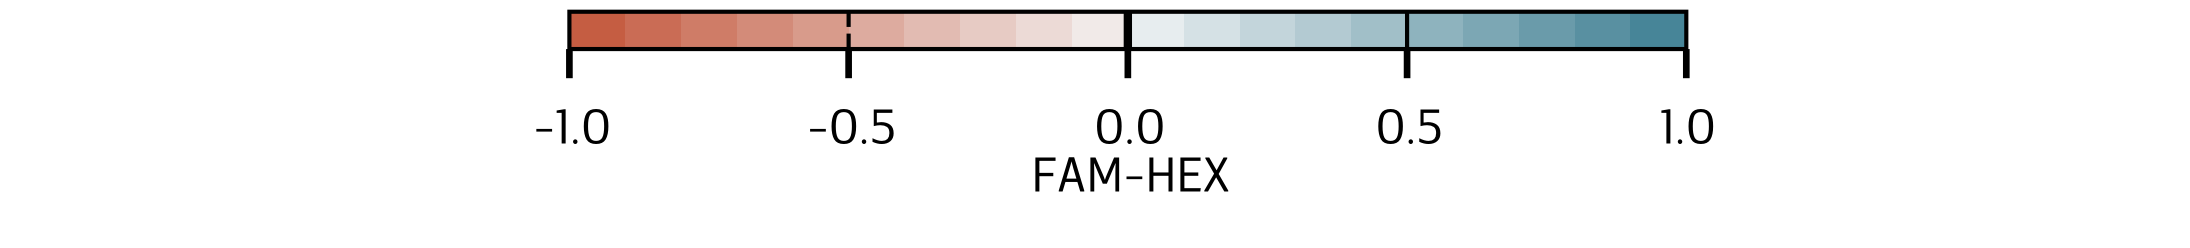

In [9]:
width = 3.65
height = 0.829
figsize = (width, height)
ticklabelsize = 6
labelsize = 6

mar_l = 0.325
mar_r = 0.22
mar_t = 0.04
mar_b = 0.27

axs = plt.subplots(1, 4, figsize=figsize, sharey=True)[1]

for i, (name, ax) in enumerate(zip(GATP.names, axs)):
    plt.sca(ax)
    x = gp.grid_vectors[name].flatten()
    dims = tuple([j for j in range(len(GATP.names)) if j != i])
    gmb.ParrayPlotter(x, sig.mean(axis=dims)).plot(line_kws={"lw": 1})

    ax.axhline(0, color="k", lw=0.5)
    ax.tick_params(axis="both", labelsize=ticklabelsize, length=1.5, width=0.6)
    ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
    ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)

    if i > 0:
        ax.set_ylabel("")
        ax.yaxis.set_tick_params(length=0)

    xticks = {
        "GBP6": [1.5, 2.5, 3.5],
        "ARG1": [2, 3, 4],
        "TMCC1": [2, 3, 4],
        "PRDM1": [3, 4, 5],
    }[name]

    ax.set_xticks(xticks)

plt.subplots_adjust(
    left=mar_l / width,
    right=1 - mar_r / width,
    top=1 - mar_t / height,
    bottom=mar_b / height,
)

savefig(fig, alias="quantum_ibex")